# **Classification problem using FMNIST dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sn
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from matplotlib import pyplot as plt

### Data Preprocessing

In [2]:
train = pd.read_csv("dataset/fashion-mnist_train.csv")
test = pd.read_csv("dataset/fashion-mnist_test.csv")

In [3]:
print("Loaded the Whole fashion mnist datasets")
print("train", train.shape)
print("test", test.shape)

Loaded the Whole fashion mnist datasets
train (60000, 785)
test (10000, 785)


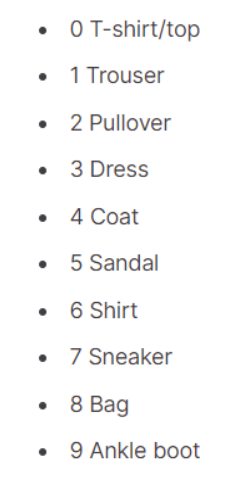

In [4]:
labels = { 0: "T-shirt/top", 1: "Trouser",
        2: "Pullover", 3: "Dress",
        4: "Coat",  5: "Sandal",
        6: "Shirt", 7: "Sneaker",
        8: "Bag", 9: "Ankle boot" }

In [5]:
#Class distribution in whole dataset
train_count={}
test_count={}
all_train_labels=train['label']
all_test_labels=test['label']

for i in range(10):
    train_count[i]=list(all_train_labels).count(i)
    test_count[i]=list(all_test_labels).count(i)

print('Whole Dataset Distribution')
data_distribution=pd.DataFrame([train_count,test_count],index=['Training','Testing'])
data_distribution

Whole Dataset Distribution


,0,1,2,3,4,5,6,7,8,9
Training,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000
Testing,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


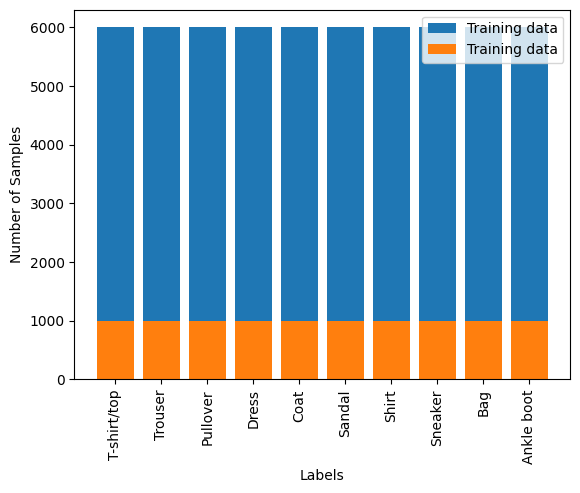

In [6]:
plt.bar([labels[i] for i in train_count.keys()],list(train_count.values()),label='Training data')
plt.bar(list(test_count.keys()),list(test_count.values()),label='Training data')
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()

In [7]:
groups_train = train.groupby('label')
train = groups_train.apply(lambda x:x.sample(frac=1)[:1000])
train = train.sample(frac=1, random_state=10).reset_index(drop=True)

groups_test = test.groupby('label')
test = groups_test.apply(lambda x:x.sample(frac=1)[:100]) # shuffled before get values
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
print("train", train.shape)
print("test", test.shape)

train (10000, 785)
test (1000, 785)


In [9]:
#Class distribution in selected dataset
train_count={}
test_count={}
all_train_labels=train['label']
all_test_labels=test['label']

for i in range(10):
    train_count[i]=list(all_train_labels).count(i)
    test_count[i]=list(all_test_labels).count(i)
print('Selected Data Distribution')
data_distribution=pd.DataFrame([train_count,test_count],index=['Training','Testing'])
data_distribution

Selected Data Distribution


,0,1,2,3,4,5,6,7,8,9
Training,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Testing,100,100,100,100,100,100,100,100,100,100


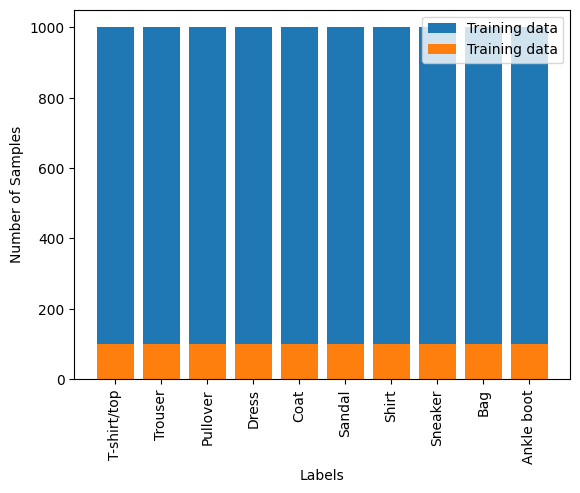

In [10]:
plt.bar([labels[i] for i in train_count.keys()],list(train_count.values()),label='Training data')
plt.bar(list(test_count.keys()),list(test_count.values()),label='Training data')
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()

In [11]:
# Making categorical data . that is labels : (0 to 9) is converted into 1d vector of length 10 
Y_train = to_categorical(train["label"], num_classes=10)
Y_test  = to_categorical(test["label"], num_classes=10)
print("Y_train Shape : ",Y_train.shape)
print("Y_test Shape : ",Y_test.shape)

Y_train Shape :  (10000, 10)
Y_test Shape :  (1000, 10)


In [12]:
X_train = train.drop(labels = ["label"],axis = 1)
#make image from the data and normalize 
X_train = X_train / 255.0
X_train = X_train.values.reshape(-1, 28, 28)

X_test = test.drop(labels = ["label"],axis = 1)
X_test = X_test / 255.0
X_test = X_test.values.reshape(-1, 28, 28)

print("X_train Shape : ",X_train.shape)
print("X_test Shape : ",X_test.shape)

X_train Shape :  (10000, 28, 28)
X_test Shape :  (1000, 28, 28)


### Data Visualization

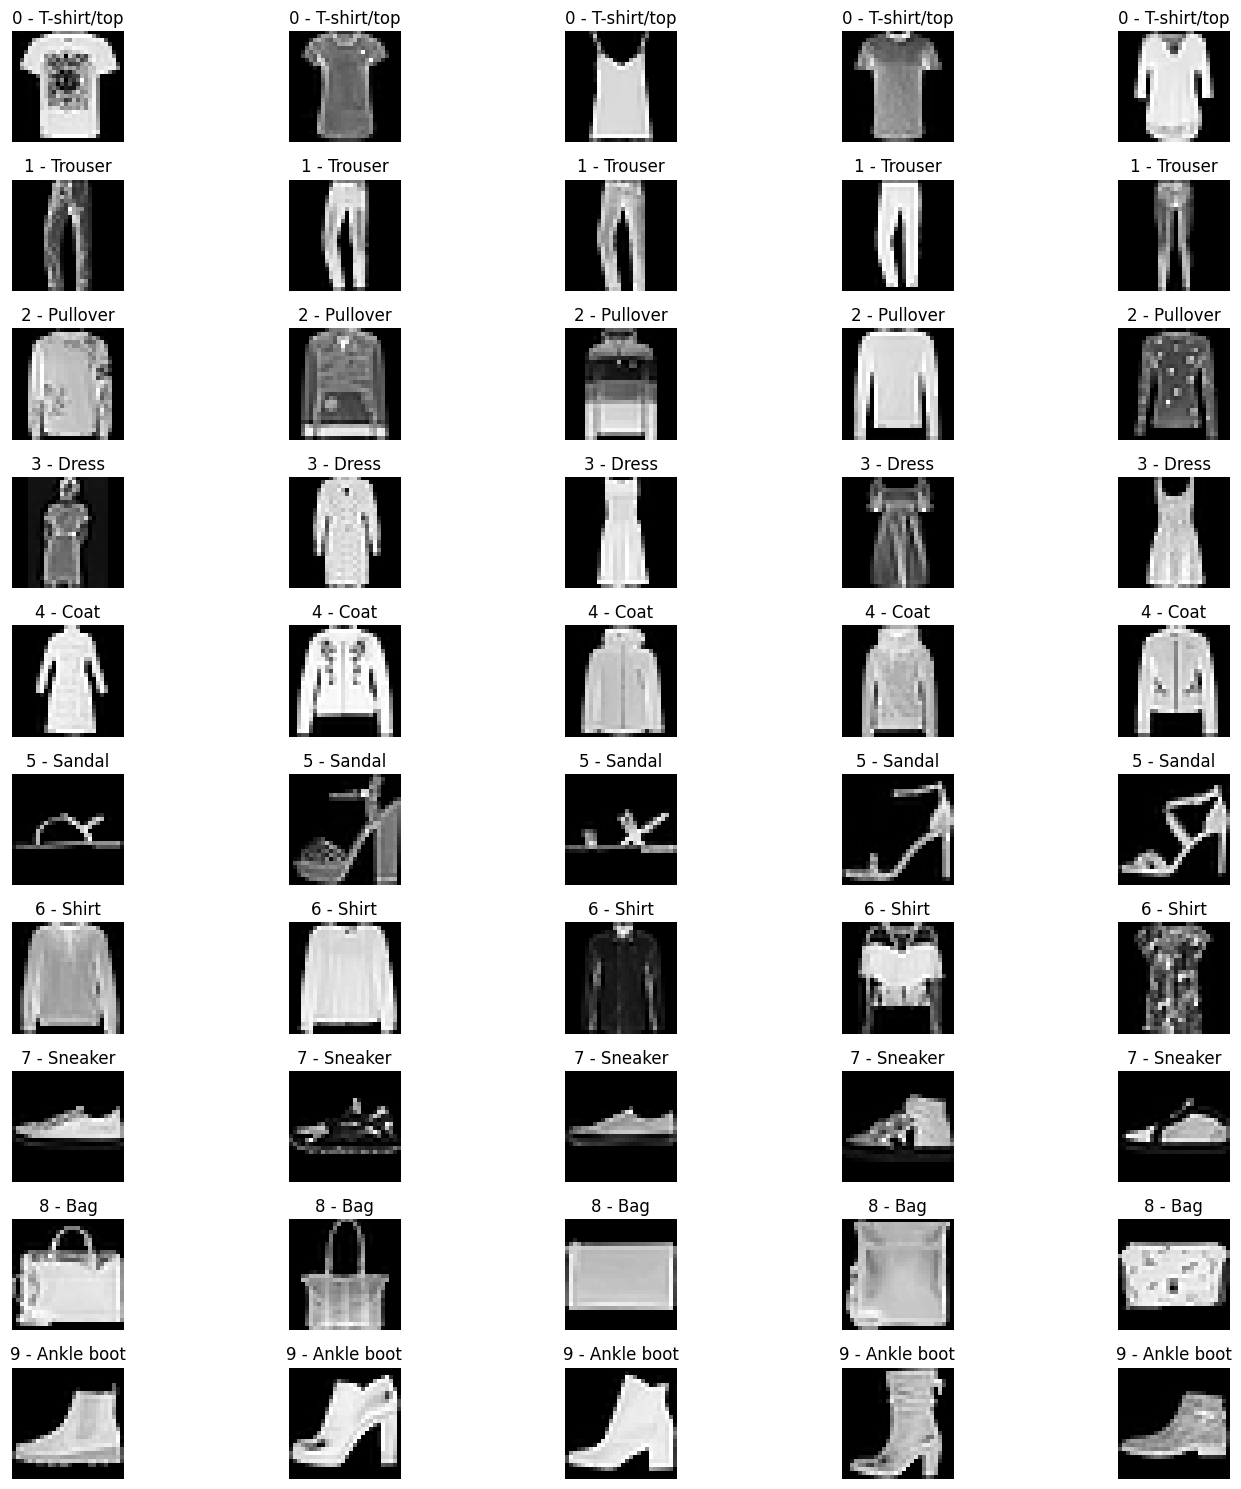

In [13]:
import matplotlib.pyplot as plt
import numpy as np

unique_labels = np.argmax(Y_train, axis=1)
unique_labels_set = set(unique_labels)
fig, axes = plt.subplots(len(unique_labels_set), 5, figsize=(15, 15))
for i, label in enumerate(unique_labels_set):
    indices = np.where(unique_labels == label)[0][:5]  # Select the first 5 images for each class
    for j, index in enumerate(indices):
        axes[i, j].imshow(X_train[index], cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'{label} - {labels[label]}')
plt.tight_layout()
plt.show()

### *Defining CNN Model*

In [14]:
classifier = Sequential()

classifier.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', input_shape=(28,28,1)))
classifier.add(BatchNormalization())

classifier.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.3))

classifier.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.3))
    
    
classifier.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.3))

classifier.add(Flatten())

classifier.add(Dense(256, activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.2))

classifier.add(Dense(128, activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.2))

classifier.add(Dense(64, activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.2))

classifier.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=METRICS)

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0

In [15]:
x_train = X_train.reshape(X_train.shape[0],28,28,1)
x_test = X_test.reshape(X_test.shape[0],28,28,1)

### *Training*

In [16]:
history = classifier.fit(x_train, Y_train, epochs=50, batch_size=32, validation_data=(x_test, Y_test), shuffle=True)

Epoch 1/50
313/313 [==============================] - 14s 18ms/step - loss: 0.7675 - accuracy: 0.7274 - precision: 0.8041 - recall: 0.6592 - val_loss: 1.4245 - val_accuracy: 0.5600 - val_precision: 0.8568 - val_recall: 0.4070
Epoch 2/50
313/313 [==============================] - 5s 15ms/step - loss: 0.5250 - accuracy: 0.8151 - precision: 0.8551 - recall: 0.7753 - val_loss: 0.4647 - val_accuracy: 0.8150 - val_precision: 0.8427 - val_recall: 0.7980
Epoch 3/50
313/313 [==============================] - 5s 15ms/step - loss: 0.4508 - accuracy: 0.8390 - precision: 0.8684 - recall: 0.8069 - val_loss: 0.3628 - val_accuracy: 0.8720 - val_precision: 0.9014 - val_recall: 0.8500
Epoch 4/50
313/313 [==============================] - 5s 16ms/step - loss: 0.3977 - accuracy: 0.8588 - precision: 0.8859 - recall: 0.8316 - val_loss: 0.3673 - val_accuracy: 0.8820 - val_precision: 0.8969 - val_recall: 0.8610
Epoch 5/50
313/313 [==============================] - 5s 16ms/step - loss: 0.3467 - accuracy: 0.875

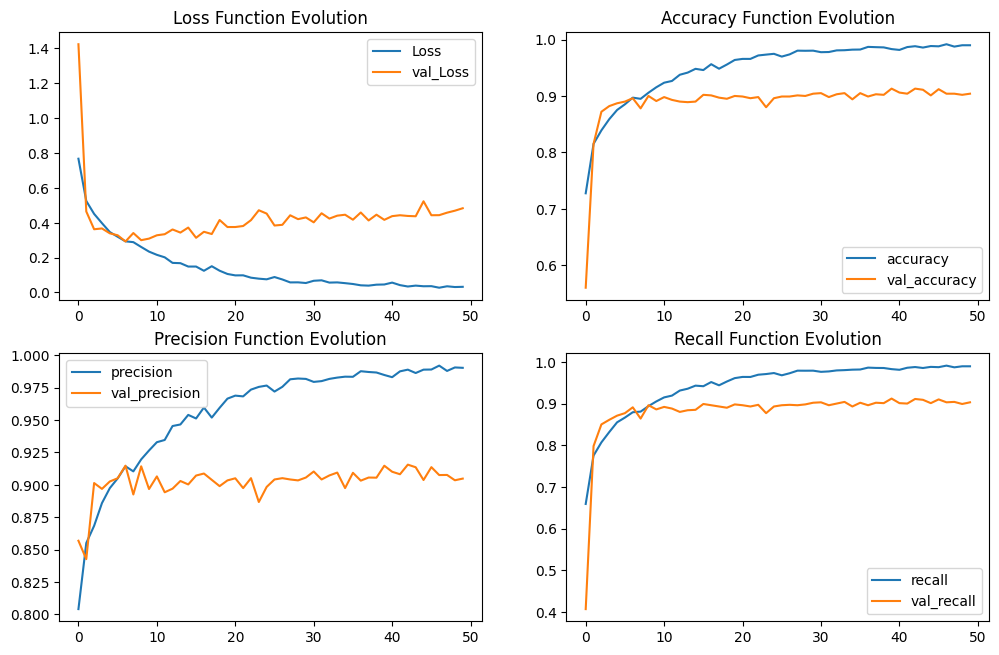

In [17]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

### Testing on Training Dataset

In [18]:
from sklearn.metrics import accuracy_score
predict_x=classifier.predict(x_train) 
Y_pred=np.argmax(predict_x,axis=1)

y_train = []
for x in Y_train:
  y_train.append(np. argmax(x, axis=None))
Y_pred = [labels[ind] for ind in Y_pred]
y_train = [labels[ind] for ind in y_train]
print("Training Accuracy : ",accuracy_score(Y_pred, y_train)*100)
train_report=pd.DataFrame(classification_report(Y_pred, y_train,output_dict=True)).transpose()
train_report

Training Accuracy :  99.98


,precision,recall,f1-score,support
Ankle boot,1.0000,1.000000,1.000000,1000.0000
Bag,1.0000,1.000000,1.000000,1000.0000
Coat,0.9990,1.000000,0.999500,999.0000
Dress,1.0000,1.000000,1.000000,1000.0000
Pullover,1.0000,1.000000,1.000000,1000.0000
Sandal,1.0000,1.000000,1.000000,1000.0000
Shirt,1.0000,0.998004,0.999001,1002.0000
Sneaker,1.0000,1.000000,1.000000,1000.0000
T-shirt/top,0.9990,1.000000,0.999500,999.0000
Trouser,1.0000,1.000000,1.000000,1000.0000


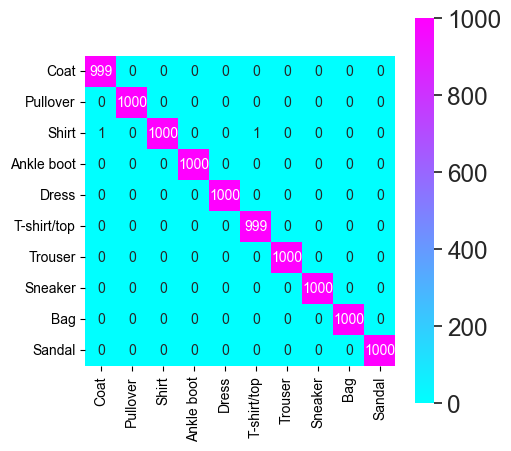

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
cm = confusion_matrix(Y_pred, y_train, labels=list(set(y_train)))
df_cm = pd.DataFrame(cm, list(set(y_train)), list(set(y_train)))
sn.set(font_scale=1.6)
sn.heatmap(df_cm,cmap='cool', annot=True, annot_kws={"size": 10}, fmt='.4g', ax=ax, square=True)
plt.show()

### Showing Wrongly Classified in Training Dataset

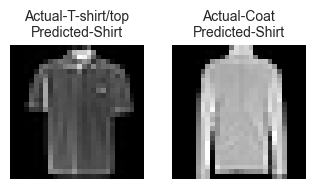

In [20]:
yyyy = classifier.predict(x_train)
yyyy=np.argmax(yyyy,axis=1)
yyyy = [labels[idx] for idx in yyyy]
plt.figure(figsize=(8,8))
plotted=0
for i in range(len(yyyy)):
    if yyyy[i]!=y_train[i]:
        plt.subplot(4,4,plotted+1)
        plt.imshow(x_train[i], cmap='gray')
        plt.axis('off')
        plt.title('Actual-{}\nPredicted-{}'.format(y_train[i],yyyy[i]),fontsize=10)
        plotted+=1
    if plotted==16:
        break

### *Testing on Testing Dataset*

In [21]:
predict_x=classifier.predict(x_test) 
Y_pred=np.argmax(predict_x,axis=1)

y_test = []
for x in Y_test:
  y_test.append(np. argmax(x, axis=None))
    
Y_pred = [labels[ind] for ind in Y_pred]
y_test = [labels[ind] for ind in y_test]
print("Testing Accuracy : ",accuracy_score(Y_pred, y_test)*100)
test_report=pd.DataFrame(classification_report(Y_pred, y_test,output_dict=True)).transpose()
test_report

Testing Accuracy :  90.4


,precision,recall,f1-score,support
Ankle boot,0.94000,0.979167,0.959184,96.000
Bag,0.97000,0.950980,0.960396,102.000
Coat,0.85000,0.885417,0.867347,96.000
Dress,0.90000,0.891089,0.895522,101.000
Pullover,0.91000,0.827273,0.866667,110.000
Sandal,0.97000,0.989796,0.979798,98.000
Shirt,0.73000,0.730000,0.730000,100.000
Sneaker,0.98000,0.924528,0.951456,106.000
T-shirt/top,0.79000,0.868132,0.827225,91.000
Trouser,1.00000,1.000000,1.000000,100.000


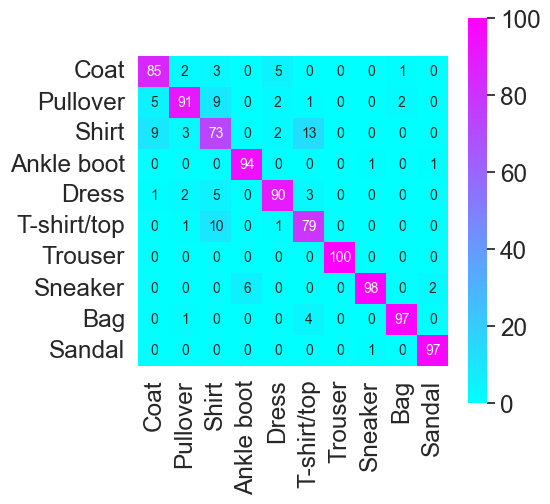

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
cm = confusion_matrix(Y_pred, y_test, labels=list(set(y_test)))
df_cm = pd.DataFrame(cm, list(set(y_test)), list(set(y_test)))
sn.set(font_scale=1.6)
sn.heatmap(df_cm,cmap='cool', annot=True, annot_kws={"size": 10}, fmt='.4g', ax=ax, square=True)
plt.show()

### *Showing Wrongly Classified in testing set*

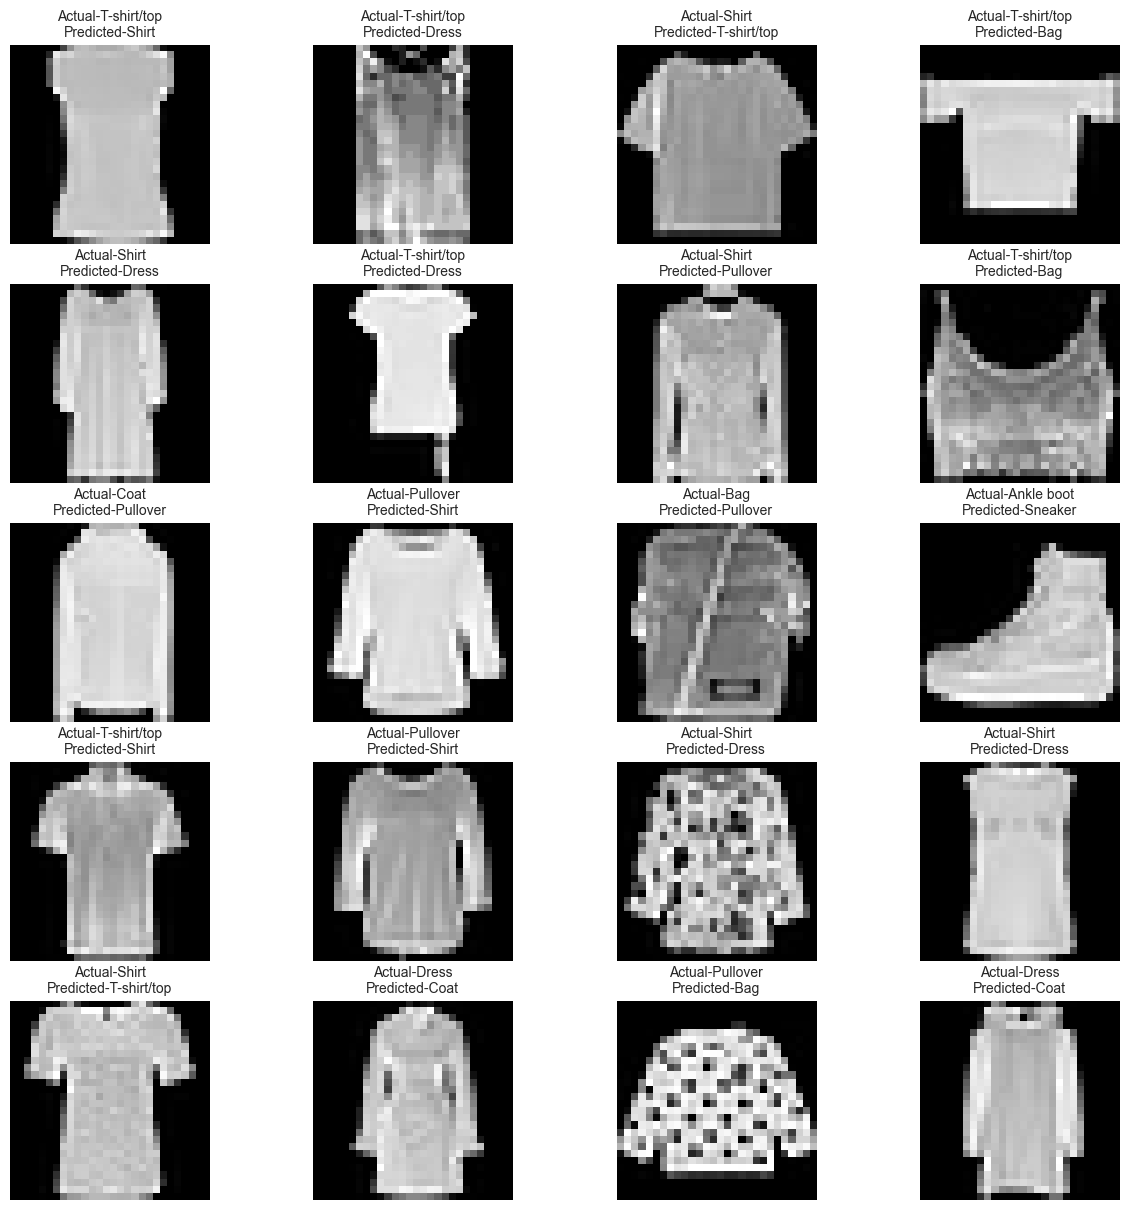

In [23]:
yyyy = classifier.predict(x_test)
yyyy=np.argmax(yyyy,axis=1)
yyyy = [labels[idx] for idx in yyyy]
plt.figure(figsize=(15,15))
plotted=0
for i in range(len(yyyy)):
    if yyyy[i]!=y_test[i]:
        plt.subplot(5,4,plotted+1)
        plt.imshow(x_test[i], cmap='gray')
        plt.axis('off')
        plt.title('Actual-{}\nPredicted-{}'.format(y_test[i],yyyy[i]),fontsize=10)
        plotted+=1
    if plotted==20:
        break